## Feed-forward Neural Network with MLP (Numpy)

In [1]:
import numpy as np

def relu(x):
    return np.maximum(x, 0)

def passthru(x):
    return x

def tanh(x):
    return np.tanh(x)

class NeuralNetwork():

    def __init__(self, input_dim=1,
                 output_dim=24,
                 units=[20,20,20],
                 activations=["relu", "relu", "relu", "passthru"]):
        if activations[-1] != "passthru":
            raise ValueError("output activation must be passthru")
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.units = units
        self.num_layers = len(units)
        
        self.activations = []
        for act in activations:
            if act == "relu":
                self.activations += [relu]
            elif act == "passthru":
                self.activations += [passthru]
            else:
                self.activations += [tanh]
    
        unit_list = [input_dim]
        for u in self.units:
            unit_list += [u, u]
        unit_list += [output_dim]
        self.shapes = []
        for l in range(self.num_layers+1):
            self.shapes += [(unit_list[2*l], unit_list[2*l+1])]
        
        self.weight = []
        self.bias = []
        self.parameter_count = 0
        idx = 0
        for shape in self.shapes:
            self.weight.append(np.zeros(shape=shape))	
            self.bias.append(np.zeros(shape=shape[1]))
            self.parameter_count += (np.product(shape) + shape[1])
            idx += 1

    def set_weights(self, model_params):
        pointer = 0
        for i in range(len(self.shapes)):
            w_shape = self.shapes[i]
            b_shape = self.shapes[i][1]
            s_w = np.product(w_shape)
            s = s_w + b_shape
            chunk = np.array(model_params[pointer:pointer+s])
            self.weight[i] = chunk[:s_w].reshape(w_shape)
            self.bias[i] = chunk[s_w:].reshape(b_shape)
            pointer += s

    def predict(self, X):
        h = np.array([X]).flatten()
        num_layers= len(self.weight)
        for i in range(num_layers):
            w = self.weight[i]
            b = self.bias[i]
            h = np.matmul(h, w) + b
            h = self.activations[i](h)
        return h

In [2]:
NN = NeuralNetwork(input_dim=5, output_dim=1, units=[5], activations=["relu","passthru"])
params = np.ones(NN.parameter_count)
NN.set_weights(params)
print (NN.predict(np.ones(5)))

[31.]


/tmp/ipykernel_8785/3315341826.py:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  NN = NeuralNetwork(input_dim=5, output_dim=1, units=[5], activations=["relu","passthru"])
/tmp/ipykernel_8785/3315341826.py:3: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  NN.set_weights(params)


## Feed-forward Neural Network with MLP (Torch)

In [3]:
import torch
import torch.nn as nn

torch_nn = nn.Sequential(
    nn.Linear(5, 5),
    nn.ReLU(),
    nn.Linear(5, 1)
)

for module in torch_nn:
    if hasattr(module, 'weight'):  # Check if the module has the 'weight' attribute
        with torch.no_grad():  # Disable gradient tracking
            module.weight = nn.Parameter(torch.ones_like(module.weight))
            if module.bias is not None:
                module.bias = nn.Parameter(torch.ones_like(module.bias))

torch_nn.forward(torch.from_numpy(np.ones(5)).float())

tensor([31.], grad_fn=<ViewBackward0>)

## Feed-forward Neural Network with MLP (Torch): Regression

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
# Synthetic dataset: y = 3*x + 2 + noise
x = torch.randn(100, 1)  # 100 data points
y = 3 * x + 2 + 0.1 * torch.randn(100, 1)  # True function with some noise

# Dataset and DataLoader for mini-batch processing
from torch.utils.data import TensorDataset, DataLoader
dataset = TensorDataset(x, y)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

model = nn.Sequential(
    nn.Linear(1, 20),  # Input features size is 1, output size is 20
    nn.ReLU(),
    nn.Linear(20, 1)  # Final layer outputting one value for regression
)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Number of epochs (iterations over the entire dataset)
num_epochs = 100

for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        optimizer.zero_grad()  # Clear existing gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update parameters
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 3.0852
Epoch [20/100], Loss: 1.1651
Epoch [30/100], Loss: 0.5188
Epoch [40/100], Loss: 0.1786
Epoch [50/100], Loss: 0.0795
Epoch [60/100], Loss: 0.1305
Epoch [70/100], Loss: 0.1452
Epoch [80/100], Loss: 0.2555
Epoch [90/100], Loss: 0.1048
Epoch [100/100], Loss: 0.0264


In [3]:
from os.path  import join
import struct
from array import array
import numpy as np
import random
import matplotlib.pyplot as plt

class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        filtered_images = []
        filtered_labels = []
        for img, label in zip(images, labels):
            if label in [1, 3]:
                filtered_images.append(img)
                filtered_labels.append(label)
        
        return filtered_images, filtered_labels

        # return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)  

# Set file paths based on added MNIST Datasets
training_images_filepath = 'data/mnist-dataset/train-images.idx3-ubyte'
training_labels_filepath = 'data/mnist-dataset/train-labels.idx1-ubyte'
test_images_filepath = 'data/mnist-dataset/t10k-images.idx3-ubyte'
test_labels_filepath = 'data/mnist-dataset/t10k-labels.idx1-ubyte'

In [4]:
# Load MINST dataset
print('Loading MNIST dataset...')
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()
print('MNIST dataset loaded.')

Loading MNIST dataset...
MNIST dataset loaded.


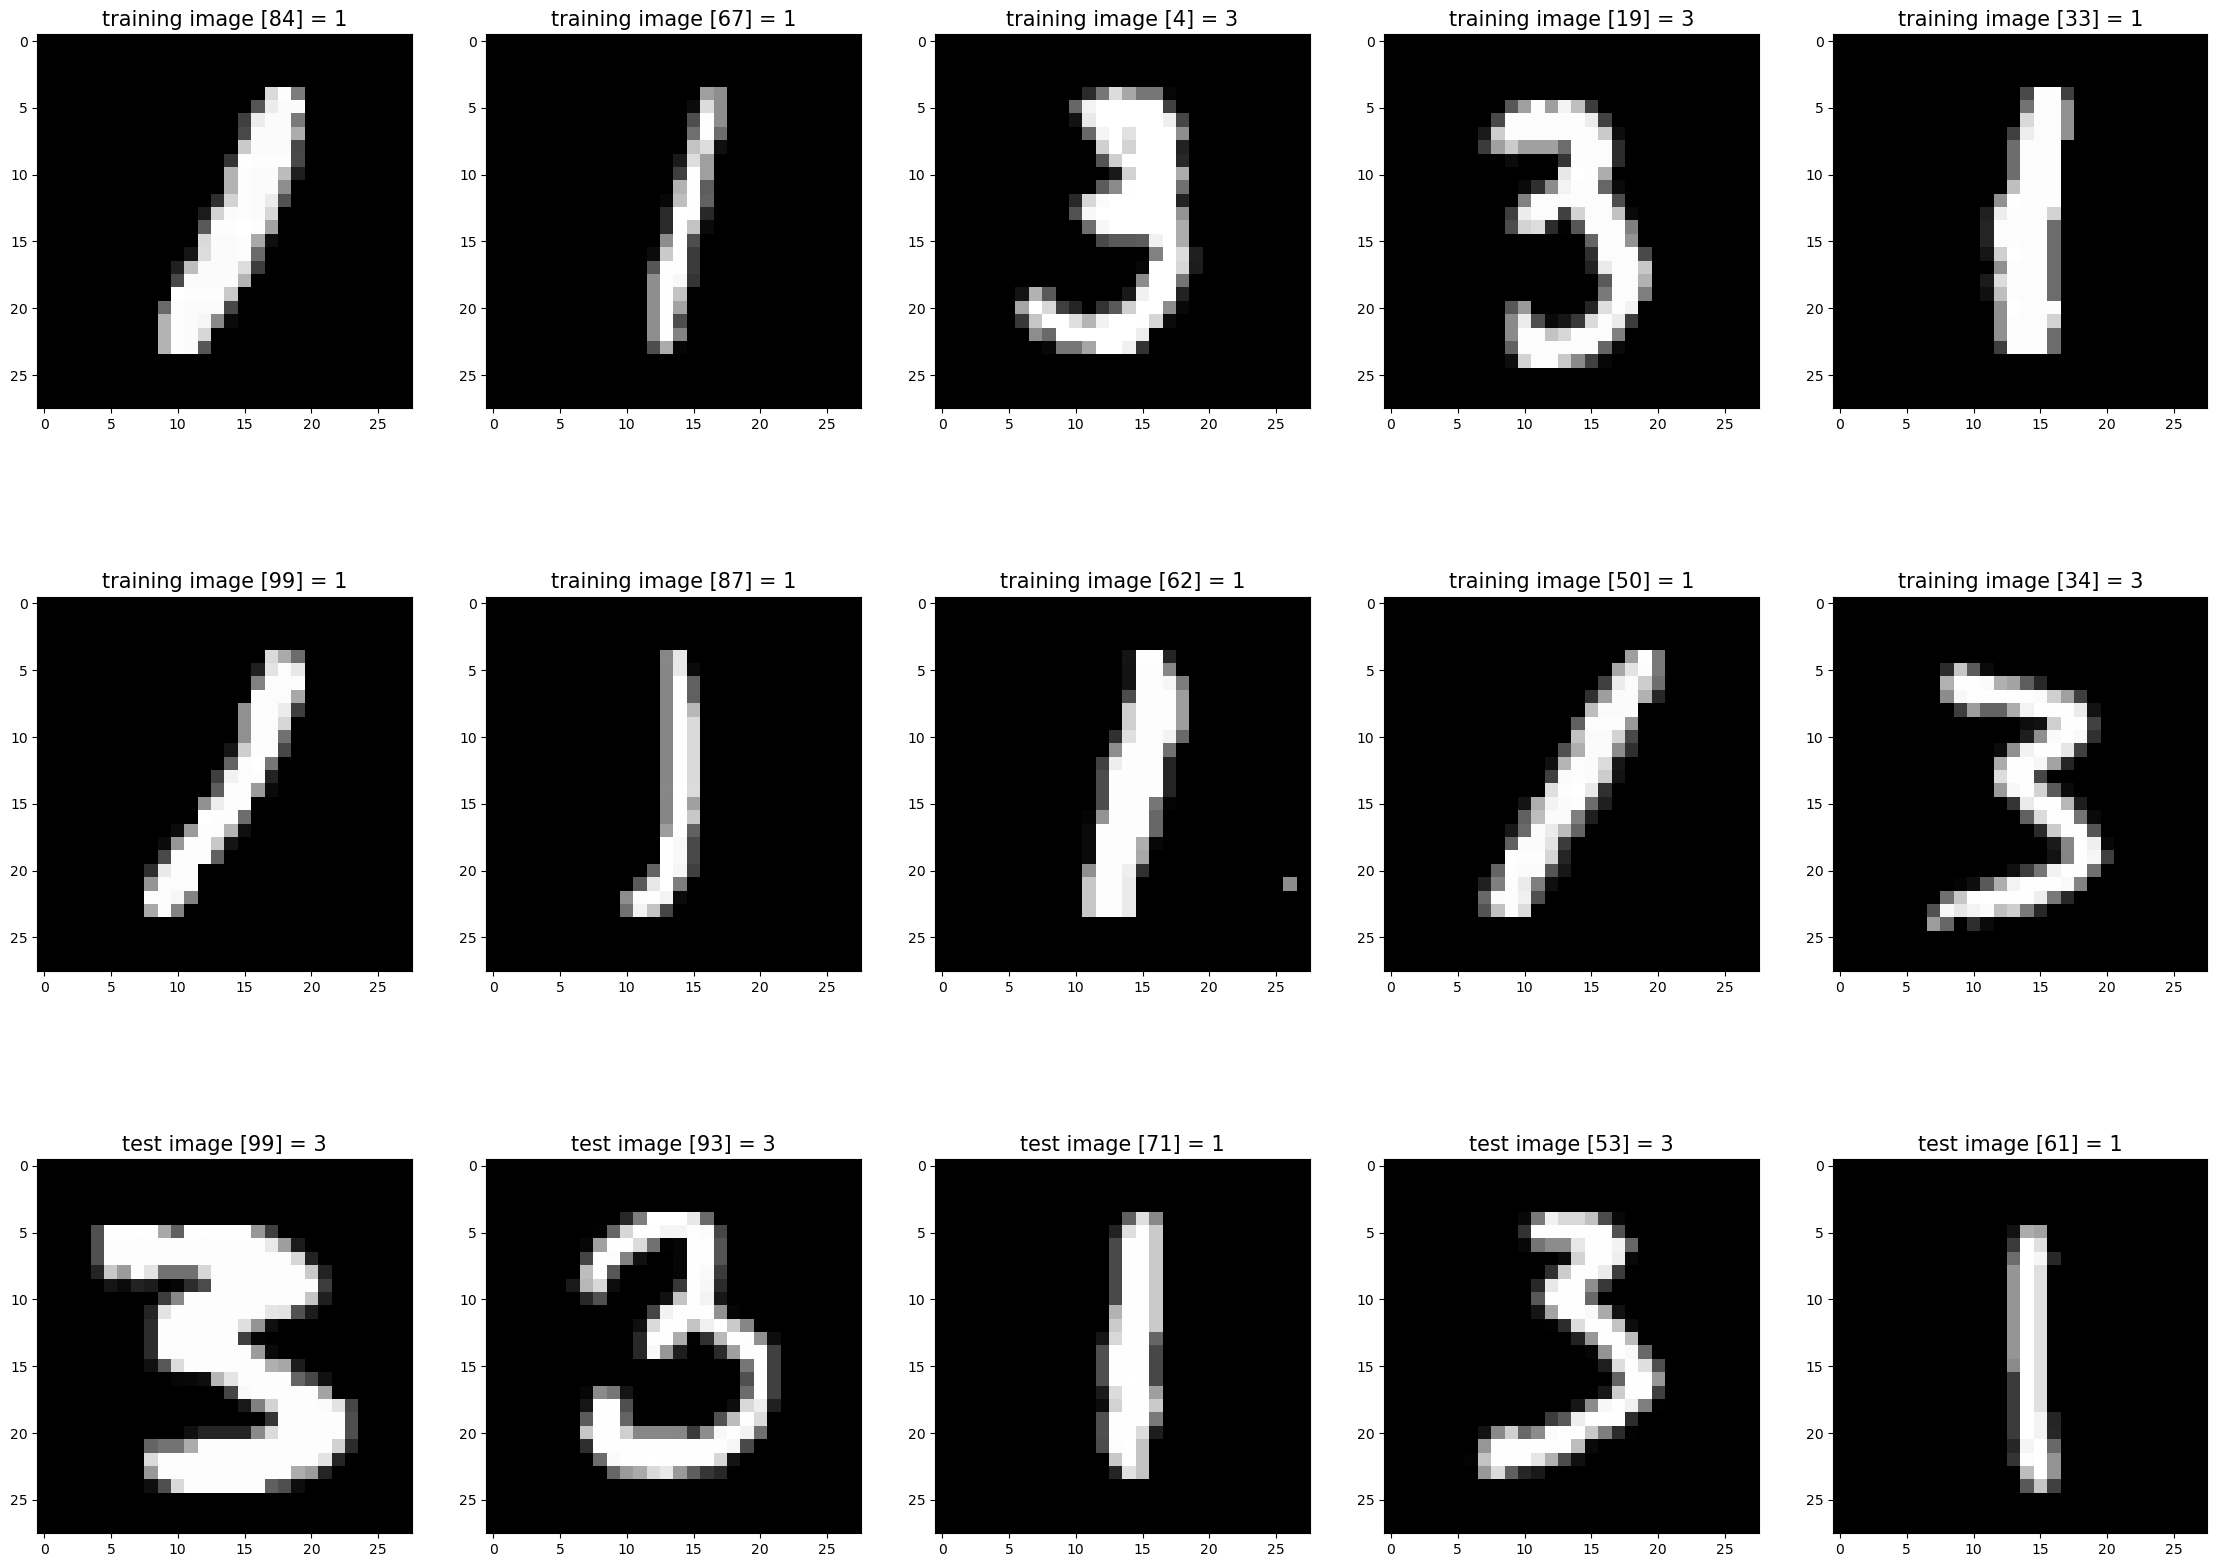

In [5]:
# Show example images
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(28, 28))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

random_images = []
for i in range(0, 10):
    r = random.randint(1, 100)
    random_images.append((x_train[r], 'training image [' + str(r) + '] = ' + str(y_train[r])))
for i in range(0, 5):
    r = random.randint(1, 100)
    random_images.append((x_test[r], 'test image [' + str(r) + '] = ' + str(y_test[r])))

show_images(list(map(lambda x: x[0], random_images)), list(map(lambda x: x[1], random_images)))